# Alternative Approaches to Perceptron

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import scipy.io as spio
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
import urllib
from urllib.request import urlopen
%matplotlib inline
import urllib.request
import datetime as dt
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
link = "http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/zipcombo.dat"
filename = 'zipcombo.dat'
urllib.request.urlretrieve(link, filename)
data = np.loadtxt(filename)     # read numpy array from fil

In [4]:
y = data[:,0]
x = data[:,1:]

# Q6 - Alternative generalization method, One vs. One

In [9]:
def allocate_training_test_sets(data,r =1/5):
    X= data[:,1:]
    y= data[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r)
    return X_train, X_test, y_train, y_test

def add_bias(x):
    x_with_bias = np.ones((x.shape[0],x.shape[1]+1))
    x_with_bias[:,:-1] = x
    return x_with_bias

#Discuss the use of the this kernel. i.e. talk about non-linear seperability. 
def Polynomial_Kernel(x1,x2,d):
    K = (x1 @ x2.T)**d
    return K

def pairwise_distance_single(X): # distances of X training data, single X matrix
    m =X.shape[0]
    n = X.shape[1]
    G = np.matmul(X,X.T)
    DG = np.diag(G).reshape(G.shape[0],1)
    distances_sq = np.matmul(DG,np.ones((G.shape[0],1)).T)+ np.matmul(np.ones((G.shape[1],1)),DG.T)-2.0*G
    return distances_sq

def pairwise_distance_double(X1,X2): # distances of X training data, double matrices, X1 and X2
    X1_pow = (X1**2).sum(axis=1).reshape(X1.shape[0],1) #sum the rows, size m1 array
    X2_pow = (X2**2).sum(axis=1).reshape(X2.shape[0],1) #sum the rows, size m2 array
    G = np.matmul(X1,X2.T)
    m1,m2 =G.shape[0],G.shape[1] 
    distances_sq = np.matmul(X1_pow,np.ones((m2,1)).T)+ np.matmul(np.ones((m1,1)),X2_pow.T)-2.0*G
    return distances_sq

def Gaussian_Kernel(distances_sq,c=1):
    K = np.exp(-c*distances_sq)
    return K

## One vs. One Pairwise Multiclass Perceptron

In [26]:
#One vs. one approach: train k*(k-1)/2 binary classifiers to identify k classes
#For example, one classifier could be trained to distinguish between digit 0 and digit 1.
#Consider symmetry when computing prediction

#Write a function that trains a binary classifier given two classes, given kernel:
def classifier_ovo(class1,class2,K,alpha_ovo,w,iter_num):
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    vote = np.sign(((alpha_ovo[:iter_num].T @K[iter_num,:iter_num]).T))
    return vote #returns a vote, within (-1,1)


def perceptron_train_ovo(x,y,d=2,kernel_choice='Polynomial'):
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    classes_num = 10 #number of classes 
    
    errors = np.zeros(m)
    
    if kernel_choice=='Polynomial':
        K_train = Polynomial_Kernel(x,x,d)
    elif kernel_choice=='Gaussian':
        pairwise_distances = pairwise_distance_single(x)
        K_train = Gaussian_Kernel(pairwise_distances,c=d)
    
    num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
    W = np.zeros((m,classes_num,classes_num)) #with bias?
    alpha = np.zeros((m,classes_num,classes_num)) 
    
    
    #iterate through training set
    for t in range(m):
        if t<1:
            alpha_prev = np.zeros((1,classes_num,classes_num)) #when t=0, the previous alpha is set to be 0
        else:
            alpha_prev = alpha[t-1,:,:] #
        
        
        #find our training set
        x_t = x[t,:]
        y_t = y[t]
        #y_arr_t = y_arr[t,:] #of size (1,10) 
        
        votes_board = np.zeros((classes_num, classes_num)) #zero on the horizontal. 
        classes_list = np.array(range(classes_num))
        
       
        for i in range(classes_num):
            c1 = classes_list[i]
            classes_rest = classes_list[classes_list>c1]
            for j in range(len(classes_rest)):
                c2 = classes_rest[j]
                w = W[:,int(c1),int(c2)]
                alpha_ovo = alpha[:,int(c1),int(c2)]
                vote = classifier_ovo(c1,c2,K_train,alpha_ovo,w,iter_num=t) #vote in {-1,1}
                votes_board[int(c1),int(c2)] = vote
                
                
        #Count the votes in the board
        votes_count = votes_board.sum(axis=0)
        pred_t = votes_count.argmax()
        
        #if t%10000==0:
            
            #print('t=',t)
            #print('label=', y_t)
            #print('predicted label=',pred_t)
        
        
        if pred_t!=y_t:
            #print('misclassification:')
            #update the alpha, and weights, for all the classes that not the true class
            num_errors +=1
            
            #increase alpha for all the positive classifier of the correct label.
            #decrease alpha for the negative classifier of the false label. 
            alpha_t = np.zeros((classes_num,classes_num)) #initialize to a 10 x 10 zero matrix
            #alpha_t[int(y_t),:] =+1
            #alpha_t[int(pred_t),:] =-1
            alpha_t[:,int(y_t)] =+1 # column belonging to correct label class +=1
            alpha_t[:,int(pred_t)] =-1 # column belonging to false predicted class -=1
            
            #store alpha_t into the matrix for future reference
            alpha[t,:,:] = alpha_t
            
            #sandwich K(x_t, x_i) for i in [1,t-1] in a zeros array of size(m). 
            #reason being weight for one class is of size(m), but we only 'have enough data' to update the first t-1 terms.  
            K_update = np.zeros((1,m))
            K_update[:,:t] = K_train[t,:t] 
            
            #Note that W is a weight matrix of size (m, 10)
            #K_update.T @alpha_t is the update for weight matrix, for every class and every training set that has been reviewed. 
            W_update = K_update.T @(alpha_t.reshape(1,100)) 
            
            W = W+ W_update.reshape(W.shape) #(1, 10) * (1,m), want (m,10)
        else:
            W = W #no change
            
        errors[t] = num_errors         
    return W,alpha, errors


def perceptron_test_ovo(x_test,x_train,y_test,W, alphas, d,kernel_choice='Polynomial'):
    m_test = x_test.shape[0]
    m_train = x_train.shape[0]
    
    if kernel_choice=='Polynomial':
        K_test = Polynomial_Kernel(x_train, x_test, d)
    elif kernel_choice=='Gaussian':
        pairwise_distances = pairwise_distance_double(x_train,x_test,d)
        K_test = Gaussian_Kernel(pairwise_distances,c=d)
    
    classes_num = 10
    classes_list = np.array(range(classes_num))
    votes_ovo =np.zeros((m_test,10,10))
    
    for i in range(classes_num):
        c1 = classes_list[i]
        classes_rest = classes_list[classes_list>c1]
        for j in range(len(classes_rest)):
            c2 = classes_rest[j]
            alphas_ovo_c1c2 = alphas[:,int(c1),int(c2)]
            vote = np.sign(alphas_ovo_c1c2.T@K_test) 
            votes_ovo[:,c1,c2] = vote
                
    sum_votes = np.sum(votes_ovo,axis=1)
    pred = sum_votes.argmax(axis=1)
    
    diff = pred - y_test
    mistakes = len(diff[diff!=0])
    return pred,mistakes

In [32]:
#Cross Validation of One vs. One
def cross_validation_ovo(matrix,d_values,k=5,kernel_choice='Polynomial'):
    #np.random.shuffle(matrix)
    kf = KFold(n_splits=k)
    error_cv_arr = np.zeros(k)
    
    for train_index, cv_index in kf.split(matrix):
        # Spit the matrix using the indices gained by the CV method and construct X and Y arrays
        matrix_train, matrix_cv = matrix[train_index], matrix[cv_index]

        X_train = matrix_train[:,0:-1]
        X_cv = matrix_cv[:,0:-1]
        y_train = matrix_train[:,-1] 
        y_cv = matrix_cv[:,-1]

        # We are only interested in the alphas and not the MSE on the training set
        W, alphas, train_errors = perceptron_train_ovo(X_train,y_train, d)
        predictions, test_errors = perceptron_test_ovo(X_cv, X_train, y_cv, W, alphas, d)
        error_cv_arrr[i] = test_errors
        i += 1
        
        return error_cv_arr.mean(), (error_cv_arr.var())**(1/2)

### Experiment on all training data and test data, d=2

In [18]:
startTime = datetime.now()
X_train, X_test, y_train, y_test = allocate_training_test_sets(data,r =1/5)
W_ovo, alphas_ovo, train_errors = perceptron_train_ovo(X_train,y_train, 2)
predictions, test_errors = perceptron_test_ovo(X_test, X_train, y_test, W_ovo, alphas_ovo, 2)
print(datetime.now() - startTime )

0:00:00.557675


In [21]:
accuracy = 1-test_errors/y_test.shape[0]
accuracy

0.9182795698924731

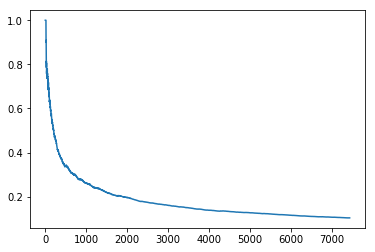

In [36]:
plt.plot(train_errors/np.arange(1,X_train.shape[0]+1))

### Basic Results  - Polynomial Kernel

In [27]:
d_arr = np.arange(1,8)
runs = 20
training_set_errors = np.zeros((len(d_arr),runs))
test_set_errors = np.zeros((len(d_arr),runs))

for d in d_arr:
    for i in range(runs):
        startTime = datetime.now()
        X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)
        W, alphas,train_errors = perceptron_train_ovo(X_train,y_train, d)
        predictions, test_error = perceptron_test_ovo(X_test,X_train, y_test,W, alphas,d)
        
        training_set_errors[d-1, i] = train_errors[-1]
        test_set_errors[d-1, i] = test_error
        print("Now doing run ", i, "/", runs, " for d=", d,".........", end='\r')
        print("Time taken: ", datetime.now() - startTime )
    

Time taken:  0:00:17.346310d= 1 .........
Time taken:  0:00:16.929518d= 1 .........
Time taken:  0:00:15.105453d= 1 .........
Time taken:  0:00:15.142342d= 1 .........
Time taken:  0:00:14.997456d= 1 .........
Time taken:  0:00:14.944090d= 1 .........
Time taken:  0:00:14.938723d= 1 .........
Time taken:  0:00:15.663484d= 1 .........
Time taken:  0:00:14.924983d= 1 .........
Time taken:  0:00:15.286689d= 1 .........
Time taken:  0:00:15.388302 d= 1 .........
Time taken:  0:00:15.327316 d= 1 .........
Time taken:  0:00:14.925340 d= 1 .........
Time taken:  0:00:15.190213 d= 1 .........
Time taken:  0:00:14.790795 d= 1 .........
Time taken:  0:00:15.708110 d= 1 .........
Time taken:  0:00:15.173589 d= 1 .........
Time taken:  0:00:15.316084 d= 1 .........
Time taken:  0:00:14.994880 d= 1 .........
Time taken:  0:00:14.862597 d= 1 .........
Time taken:  0:00:12.396770d= 2 .........
Time taken:  0:00:12.295094d= 2 .........
Time taken:  0:00:12.672932d= 2 .........
Time taken:  0:00:12.666

In [29]:
means_std = []
for d in d_arr:
    data_t = []
    data_t.append("{0:.4f} +- {1:.4f}".format(training_set_errors[d-1].mean() / len(y_train), \
                                            np.std(training_set_errors[d-1]) / len(y_train)))
    data_t.append("{0:.4f} +- {1:.4f}".format(test_set_errors[d-1].mean() / len(y_test), \
                                            np.std(test_set_errors[d-1]) / len(y_test)))
    means_std.append(data_t)
    
df = pd.DataFrame(data=means_std, index=d_arr, columns=['Training set error rate', 'Test set error rate'])
df

,Training set error rate,Test set error rate
1,0.2092 +- 0.0029,0.1720 +- 0.0366
2,0.1385 +- 0.0022,0.0955 +- 0.0152
3,0.1181 +- 0.0029,0.0707 +- 0.0054
4,0.1105 +- 0.0026,0.0661 +- 0.0115
5,0.1056 +- 0.0024,0.0641 +- 0.0087
6,0.1051 +- 0.0016,0.0600 +- 0.0054
7,0.1045 +- 0.0021,0.0626 +- 0.0088


### Cross Validation - Polynomial Kernel

In [37]:
# This might need to be cleared up
class Confusion:
    def __init__(self, x, y, pred):
        self.x = x
        self.y = y
        self.pred = pred

In [ ]:
runs = 10

d_stars = np.zeros(runs)
test_errors = np.zeros(runs)
confusion = np.zeros((10, 10))

confusion_examples = dict()
for i in range(10):
    confusion_examples[i] = []

mistakes_per_run = np.zeros(x.shape[0])
    
for j in range(runs):
    print("WARNING: Change the number of runs to 20!!!")
    # In each run we will iterate through the d array and use all possible values of d
    
    # Allocate 80/20 percent for training and test set
    X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)

    error_CV_means = np.zeros(len(d_arr))
    for i in range(len(d_arr)):
        print("Now doing run ", j, "/", runs, " for d=", d_arr[i], ".........", end='\r')
        error_CV_mean, _ = cross_validation(X_train, y_train, d_arr[i], k=5)
        error_CV_means[i] = error_CV_mean

    # Train in whole 80% now with d_star
    d_stars[j] = CV_means.argmin()
    
    W, alphas,train_errors = perceptron_train_ovo(X_train,y_train, d_stars[j])
    predictions, test_error = perceptron_test_ovo(X_test,X_train, y_test,W, alphas, d_stars[j])
        
    for i in range(len(y_train)):
        pred_label = preds_train[i].argmax()
        if pred_label != y_train[i]:
            confusion[int(y_train[i]), pred_label] += 1
            confusion_examples[int(y_train[i])].append(Confusion(X_train[i], y_train[i], pred_label))
    # END WRONG
    
    test_errors[j] =  test_error/ len(y_test)
    
    # Test in all the data set, so that we know which ones
    # are the "toughest" to predict in the whole data set. We can't really just do it on 
    # either the training or test set, as it is randomly split so order will not be pertained.
    _, preds_all, confidences = perceptron_test(x, X_train, y, W, alphas, d_stars[j])
    for i in range(x.shape[0]):
        pred_label = preds_all[i].argmax()
        if pred_label != y[i]:
            mistakes_per_run[i] += 1